In [4]:
pip install pyarrow geoarrow-pyarrow geopandas earthaccess jupyterlab_vim

  Using cached geoarrow_pyarrow-0.1.2-py3-none-any.whl.metadata (613 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 52.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.7 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 4.0.11
    Uninstalling jupyterlab-4.0.11:
      Successfully uninstalled jupyterlab-4.0.11
Note: you may need to restart the kernel to use updated packages.


In [1]:
import h5py
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import geoarrow.pyarrow as ga
from geoarrow.pyarrow import io
import geopandas as gpd
import numpy as np
import shapely
from datetime import datetime

import json
import earthaccess
from earthaccess.results import DataGranule
import fsspec

In [2]:
#earthaccess.login()
results = earthaccess.search_data(
    short_name="ATL08",
    cloud_hosted=True,
    temporal=("2023-09-02", "2023-09-04"),
    count=-1
)

Granules found: 307


In [3]:
sorted_results = sorted(results, key=lambda r : datetime.strptime(r['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'], '%Y-%m-%dT%H:%M:%S.%fZ'))

In [4]:
def result_bbox(result: DataGranule):
    points = result["umm"]["SpatialExtent"]["HorizontalSpatialDomain"]["Geometry"]["GPolygons"][0]["Boundary"]["Points"]

    longitudes = [point['Longitude'] for point in points]
    latitudes = [point['Latitude'] for point in points]

    min_lon, min_lat = min(longitudes), min(latitudes)
    max_lon, max_lat = max(longitudes), max(latitudes)
    bbox = shapely.geometry.box(min_lon, min_lat, max_lon, max_lat)
    return bbox

In [5]:
def results_bbox(results: list[DataGranule]):
    union_bbox = result_bbox(results[0])
    for result in results:
        bbox = result_bbox(result)  
        union_bbox = union_bbox.union(bbox)
    return union_bbox.envelope

In [6]:
bbox = results_bbox(results)

In [7]:
results[0].data_links(access="direct")[0]

's3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902002616_11272010_006_01.h5'

In [8]:
s3 = fsspec.filesystem('s3')

In [9]:
f = s3.open(results[0].data_links(access="direct")[0], 'rb')
file = h5py.File(f)
file

<HDF5 file "ATL08_20230902002616_11272010_006_01.h5>" (mode r)>

In [10]:
land_segments_group = file["gt1l"]["land_segments"]
canopy_group = file["gt1l"]["land_segments"]["canopy"]
terrain_group = file["gt1l"]["land_segments"]["terrain"] 

In [11]:
def datasets_to_fields(group: h5py.Group):
    fields = []
    for key in group.keys():
        if isinstance(group[key], h5py.Dataset):
            dtype = group[key].dtype
            numpy_dtype = dtype.newbyteorder("=")
            arrow_type = pa.from_numpy_dtype(numpy_dtype)
            fields.append((key, arrow_type))
    return fields

In [12]:
geo_metadata = {
    "columns": {
        "geometry": {
            "bbox": [
                -180.0,
                -90.0,
                180.0,
                83.6451
            ],
            "covering": {
                "bbox": {
                    "xmax": [
                        "bbox",
                        "xmax"
                    ],
                    "xmin": [
                        "bbox",
                        "xmin"
                    ],
                    "ymax": [
                        "bbox",
                        "ymax"
                    ],
                    "ymin": [
                        "bbox",
                        "ymin"
                    ]
                }
            },
            "crs": {
                "$schema": "https://proj.org/schemas/v0.6/projjson.schema.json",
                "area": "World.",
                "bbox": {
                    "east_longitude": 180,
                    "north_latitude": 90,
                    "south_latitude": -90,
                    "west_longitude": -180
                },
                "coordinate_system": {
                    "axis": [
                        {
                            "abbreviation": "Lon",
                            "direction": "east",
                            "name": "Geodetic longitude",
                            "unit": "degree"
                        },
                        {
                            "abbreviation": "Lat",
                            "direction": "north",
                            "name": "Geodetic latitude",
                            "unit": "degree"
                        }
                    ],
                    "subtype": "ellipsoidal"
                },
                "datum_ensemble": {
                    "accuracy": "2.0",
                    "ellipsoid": {
                        "inverse_flattening": 298.257223563,
                        "name": "WGS 84",
                        "semi_major_axis": 6378137
                    },
                    "id": {
                        "authority": "EPSG",
                        "code": 6326
                    },
                    "members": [
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1166
                            },
                            "name": "World Geodetic System 1984 (Transit)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1152
                            },
                            "name": "World Geodetic System 1984 (G730)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1153
                            },
                            "name": "World Geodetic System 1984 (G873)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1154
                            },
                            "name": "World Geodetic System 1984 (G1150)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1155
                            },
                            "name": "World Geodetic System 1984 (G1674)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1156
                            },
                            "name": "World Geodetic System 1984 (G1762)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1309
                            },
                            "name": "World Geodetic System 1984 (G2139)"
                        }
                    ],
                    "name": "World Geodetic System 1984 ensemble"
                },
                "id": {
                    "authority": "OGC",
                    "code": "CRS84"
                },
                "name": "WGS 84 (CRS84)",
                "scope": "Not known.",
                "type": "GeographicCRS"
            },
            "edges": "planar",
            "encoding": "WKB",
            "geometry_types": [
                "Point",
            ]
        }
    },
    "primary_column": "geometry",
    "version": "1.1.0-dev"
}

In [13]:
geo_metadata["columns"]["geometry"]["bbox"] = list(bbox.bounds)

In [14]:
land_segment_fields = datasets_to_fields(land_segments_group)
geometry_field = pa.field("geometry", pa.binary(), metadata={
    "encoding": "WKB",
    "geometry_types": "POINT"
})
land_segment_fields.append(geometry_field)

canopy_fields = datasets_to_fields(canopy_group)
terrain_fields = datasets_to_fields(terrain_group)

fields = land_segment_fields + canopy_fields + terrain_fields

metadata = json.dumps(geo_metadata).encode('utf-8')
schema = pa.schema(fields, metadata={b"geo": metadata})
len(schema)

88

In [15]:
def get_group_chunks(group: h5py.Group, offset: int, chunk_size: int) -> list[np.array]:
    chunks = []
    for key in group.keys():
        if isinstance(group[key], h5py.Dataset):
            if len(group[key].chunks) == 1:
                chunks.append(group[key][offset:offset+chunk_size])
            # Handle variables with land segment chunking
            elif len(group[key].chunks) == 2:
                chunks.append(group[key][offset:offset+chunk_size, 0])
    return chunks

In [16]:
results_subset = sorted_results[0:20]

In [27]:
def chunks_to_tables(result: DataGranule, fs):
    tables = []
    url = result.data_links(access="direct")[0]
    print(url)
    with fs.open(url, 'rb') as f:
        file = h5py.File(f)
        land_segments_group = file["gt1l"]["land_segments"]
        canopy_group = file["gt1l"]["land_segments"]["canopy"]
        terrain_group = file["gt1l"]["land_segments"]["terrain"] 

        chunk_size = land_segments_group["latitude"].chunks[0]
        size = land_segments_group["latitude"].size
        number_of_chunks = (size // chunk_size) + 1
        
        for n in range(number_of_chunks):
            offset = n * chunk_size
            land_segment_chunks = get_group_chunks(land_segments_group, offset, chunk_size)
            # Populate geometry field
            geometries = []
            for lat, lon in zip(
                land_segments_group["latitude"][offset:offset+chunk_size],
                land_segments_group["longitude"][offset:offset+chunk_size]
            ):
                point = shapely.Point(lon, lat)
                point_wkb = shapely.to_wkb(point, flavor="iso")
                geometries.append(point_wkb)
            land_segment_chunks.append(geometries)

            canopy_chunks = get_group_chunks(canopy_group, offset, chunk_size)
            terrain_chunks = get_group_chunks(terrain_group, offset, chunk_size)
            chunks = land_segment_chunks + canopy_chunks + terrain_chunks
            table = pa.Table.from_arrays(chunks, schema=schema)   
            tables.append(table)
    return tables

In [37]:
num_files_per_group = 10
for i in range(0, len(results_subset), num_files_per_group):
    print(i)
    result_group_tables = []
    results_group = results_subset[i:i+num_files_per_group]
    table_writer = pq.ParquetWriter(f'output.parquet_{i}', schema)
    for result in results_group:
        results_tables = chunks_to_tables(result, s3)
        result_group_tables.extend(results_tables)
        
    combined_table = pa.concat_tables(result_group_tables)
    table_writer.write_table(combined_table)
    table_writer.close()

0
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902002616_11272010_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902003357_11272011_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902003940_11272012_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902004721_11272013_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902005323_11272014_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902010026_11282001_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902012632_11282005_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902013157_11282006_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902014027_11282007_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902014729_1128200

In [35]:
df = pd.read_parquet("output.parquet_2")
df["geometry"]

0        b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\n\x1fB@...
1        b'\x01\x01\x00\x00\x00\x00\x00\x00`\xed\x1eB@\...
2        b'\x01\x01\x00\x00\x00\x00\x00\x00\x80\xd0\x1e...
3        b'\x01\x01\x00\x00\x00\x00\x00\x00`\xb3\x1eB@\...
4        b'\x01\x01\x00\x00\x00\x00\x00\x00`\x95\x1eB@\...
                               ...                        
14168    b'\x01\x01\x00\x00\x00\x00\x00\x00`\xeb\xa37@\...
14169    b'\x01\x01\x00\x00\x00\x00\x00\x00@\xe5\xa37@\...
14170    b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\xde\xa3...
14171    b'\x01\x01\x00\x00\x00\x00\x00\x00 \xd8\xa37@\...
14172    b'\x01\x01\x00\x00\x00\x00\x00\x00\xa0\xd1\xa3...
Name: geometry, Length: 14173, dtype: object

<Axes: xlabel='longitude', ylabel='latitude'>

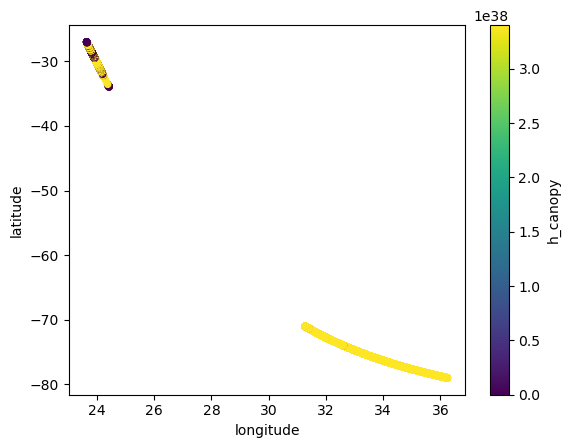

In [36]:
df.plot.scatter(x='longitude', y='latitude', c="h_canopy")

In [25]:
gdf = gpd.read_parquet('output.parquet')
gdf

,asr,atlas_pa,beam_azimuth,beam_coelev,brightness_flag,cloud_flag_atm,cloud_fold_flag,delta_time,delta_time_beg,delta_time_end,...,h_te_min,h_te_mode,h_te_rh25,h_te_skew,h_te_std,h_te_uncertainty,n_te_photons,photon_rate_te,subset_te_flag,terrain_slope
0,0.037292,0.006579,-0.989385,1.564218,0,1,0,1.788500e+08,1.788500e+08,1.788500e+08,...,-59.009117,-58.100002,-58.458748,-1.035423,0.202522,1.214998,48,0.363636,1,0.000431
1,0.037292,0.006579,-0.989408,1.564218,0,1,0,1.788500e+08,1.788500e+08,1.788500e+08,...,-58.806126,-58.200001,-58.372383,-0.570854,0.165525,0.777007,75,0.572519,1,0.000136
2,0.037292,0.006581,-0.989259,1.564216,0,1,0,1.788500e+08,1.788500e+08,1.788500e+08,...,-58.670586,-58.100002,-58.296074,-0.100937,0.267739,0.894592,65,0.488722,1,0.003831
3,0.078482,0.006580,-0.989373,1.564216,0,1,0,1.788500e+08,1.788500e+08,1.788500e+08,...,-58.703823,-58.200001,-58.282658,-0.388688,0.166063,0.437570,133,0.985185,1,-0.001172
4,0.078482,0.006579,-0.989195,1.564217,0,1,0,1.788500e+08,1.788500e+08,1.788500e+08,...,-59.061935,-58.200001,-58.388840,-0.917119,0.190298,0.344835,169,1.270677,1,-0.001682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74314,0.054731,0.003648,0.637989,1.567148,0,1,0,1.788547e+08,1.788547e+08,1.788547e+08,...,31.998108,32.799999,32.538788,-0.059736,0.313877,0.277533,118,1.123810,1,0.003397
74315,0.051224,0.003647,0.638020,1.567150,0,1,0,1.788547e+08,1.788547e+08,1.788547e+08,...,32.145805,33.600002,32.762531,-0.298012,0.477365,0.316179,105,0.929204,1,-0.011701
74316,0.051224,0.003647,0.638198,1.567149,0,1,0,1.788547e+08,1.788547e+08,1.788547e+08,...,31.733986,32.400002,32.065979,0.350368,0.284168,0.260624,124,1.137615,1,-0.002172
74317,0.051224,0.003648,0.638264,1.567148,0,1,0,1.788547e+08,1.788547e+08,1.788547e+08,...,32.011852,32.799999,32.374859,-0.076176,0.329126,0.393781,83,0.775701,1,0.002311


In [162]:
table = pq.read_table('output.parquet')
table.schema.metadata

{b'geo': b'{"columns": {"geometry": {"bbox": [-180.0, -90.0, 180.0, 83.6451], "covering": {"bbox": {"xmax": ["bbox", "xmax"], "xmin": ["bbox", "xmin"], "ymax": ["bbox", "ymax"], "ymin": ["bbox", "ymin"]}}, "crs": {"$schema": "https://proj.org/schemas/v0.6/projjson.schema.json", "area": "World.", "bbox": {"east_longitude": 180, "north_latitude": 90, "south_latitude": -90, "west_longitude": -180}, "coordinate_system": {"axis": [{"abbreviation": "Lon", "direction": "east", "name": "Geodetic longitude", "unit": "degree"}, {"abbreviation": "Lat", "direction": "north", "name": "Geodetic latitude", "unit": "degree"}], "subtype": "ellipsoidal"}, "datum_ensemble": {"accuracy": "2.0", "ellipsoid": {"inverse_flattening": 298.257223563, "name": "WGS 84", "semi_major_axis": 6378137}, "id": {"authority": "EPSG", "code": 6326}, "members": [{"id": {"authority": "EPSG", "code": 1166}, "name": "World Geodetic System 1984 (Transit)"}, {"id": {"authority": "EPSG", "code": 1152}, "name": "World Geodetic Sy